## 一.线性回归
    线性回归输出是连续值，因此不适用于回归问题；
    Softmax回归输出是是离散值，因为适用于分类问题。
### 1.线性回归要素
    模型: 
        表达式：
$$\hat{y} = x_1 w_1 + x_2 w_2 + b,$$

        模型训练:
            训练数据
            损失函数：
$$\ell^{(i)}(w_1, w_2, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2,$$
$$\ell(w_1, w_2, b) =\frac{1}{n} \sum_{i=1}^n \ell^{(i)}(w_1, w_2, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right)^2.$$
在模型训练中，我们希望找出一组模型参数，记为$w_1^*, w_2^*, b^*$，来使得训练样本平均损失最小：

$$w_1^*, w_2^*, b^* = \operatorname*{argmin}_{w_1, w_2, b}\  \ell(w_1, w_2, b).$$

            优化算法:
                解析解：误差最小化问题的解可以直接用公式表达出来
                数值解：大多数深度学习模型并没有解析解，只能通过优化算法有限次迭代模型参数来尽可能降低损失函数的值
                       小批量随机梯度下降：批量大小和学习率是认为设定的，叫做超参数
                        
        模型预测
### 2.线性回归表示方法
    神经网络图
    矢量计算表达式

## 二.线性回归--从0开始实现

In [1]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random

### 1.生成数据集
    numpy.random.normal(loc=0.0, scale=1.0, size=None)
    loc：float
        此概率分布的均值（对应着整个分布的中心centre）
    scale：float
        此概率分布的标准差（对应于分布的宽度，scale越大越矮胖，scale越小，越瘦高）
    size：int or tuple of ints
        输出的shape，默认为None

In [5]:
num_inputs=2
num_examples=1000
true_w=[2,-3.4]
true_b=4.2
features=nd.random.normal(scale=1,shape=(num_examples,num_inputs))
labels=true_w[0]*features[:,0]+true_w[1]*features[:,1]+true_b
labels+=nd.random.normal(scale=0.01,shape=labels.shape)

In [7]:
features[0],labels[0]

(
 [ 1.46422136 -1.30581355]
 <NDArray 2 @cpu(0)>, 
 [ 11.56820869]
 <NDArray 1 @cpu(0)>)

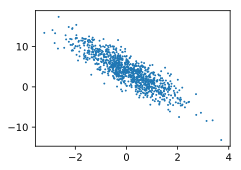

In [12]:
def use_svg_display():
    # 用矢量图表示
    display.set_matplotlib_formats('svg')
    
def set_figsize(figsize=(3.5,2.5)):
    #set_matplotlib_formats('svg')
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize']=figsize
    
set_figsize()
plt.scatter(features[:,1].asnumpy(),labels.asnumpy(),1)
# plt.show()

### 2.读取数据

In [13]:
# 每次返回batch_size(批量大小)个随机样本的特征和标签
# 此函数已保存在gluonbook包中方便以后使用
def data_iter(batch_size,features,labels):
    num_examples=len(features)
    print("长度：",num_examples)  # 1000,行数
    indices=list(range(num_examples)) 
#     print("indices：",indices)  # 0-999
    random.shuffle(indices) # 样本的读取顺序是随机的。
    for i in range(0,num_examples,batch_size):
        j=nd.array(indices[i:min(i+batch_size,num_examples)])
        yield features.take(j),labels.take(j) # take 函数根据索引返回对应元素。

In [14]:
# 每个批量的特征形状为（10， 2），分别对应批量大小和输入个数；标签形状为批量大小。
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

长度： 1000

[[-1.47309673  0.51170051]
 [-0.62007689  0.17650913]
 [ 0.4235462   1.04859841]
 [-0.41774216 -0.08433739]
 [-1.27329004  1.49360824]
 [-0.82431918  1.08587742]
 [-0.87772518  0.85446167]
 [-1.80922961  0.20077945]
 [-1.72878349 -0.31445047]
 [ 1.13518822 -0.249229  ]]
<NDArray 10x2 @cpu(0)> 
[-0.48597527  2.35971498  1.48185754  3.65126276 -3.42484856 -1.14062166
 -0.4606204  -0.1011095   1.81156445  7.31775475]
<NDArray 10 @cpu(0)>


### 3.初始化模型参数

In [15]:
# 将权重初始化成均值为 0 标准差为 0.01 的正态随机数，偏差则初始化成 0。
w=nd.random.normal(scale=0.01,shape=(num_inputs,1))
b=nd.zeros(shape=(1,))

In [16]:
w,b

(
 [[-0.00593289]
  [ 0.00363338]]
 <NDArray 2x1 @cpu(0)>, 
 [ 0.]
 <NDArray 1 @cpu(0)>)

In [17]:
# 创建梯度，需要对这些参数求梯度来迭代参数的值
w.attach_grad() # 申请存储梯度所需要的内存
b.attach_grad()

### 4.定义模型

In [18]:
# 线性回归的矢量计算表达式的实现
# 本函数已保存在 gluonbook 包中方便以后使用。
def linreg(X,w,b):
    return nd.dot(X,w)+b # dot做矩阵乘法

### 5.定义损失函数

In [19]:
# 使用平方损失来定义线性回归的损失函数
# 本函数已保存在 gluonbook 包中方便以后使用。
def squared_loss(y_hat,y):
    return(y_hat-y.reshape(y_hat.shape))**2/2 # y_hat是线性回归对真实价格 y 的预测或估计
    # 为什么要用reshape?

### 6.定义优化算法

In [20]:
# 使用sgd函数实现小批量随机梯度下降算法
# 通过不断迭代模型参数来优化损失函数，这里自动求导模块计算得来的梯度是一个批量样本的梯度和，将它除以批量大小来得到平均值。
# 本函数已保存在 gluonbook 包中方便以后使用。
def sgd(params,lr,batch_size):
    for param in params:
        param[:]=param-lr*param.grad/batch_size

### 7.训练模型

In [21]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要 num_epochs 个迭代周期。
    # 在一个迭代周期中，使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。
    # X 和 y 分别是小批量样本的特征和标签。
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # l 是有关小批量 X 和 y 的损失。
        l.backward()  # 小批量的损失对模型参数求梯度。
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数。
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

长度： 1000
epoch 1, loss 0.054285
长度： 1000
epoch 2, loss 0.000194
长度： 1000
epoch 3, loss 0.000001


In [22]:
true_w,w

([2, -3.4], 
 [[ 1.99944496]
  [-3.39937043]]
 <NDArray 2x1 @cpu(0)>)

In [23]:
true_b,b

(4.2, 
 [ 4.19909906]
 <NDArray 1 @cpu(0)>)